In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
%pip install plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
null performances after coercion: 281
after saturation filter 2201
after filter num benchmarks 1401
after merge with model versions 1397
after merge with benchmark dates 1397
Original number of rows: 1397
Number of rows after aggregation: 967


In [3]:
anchor_mode = "benchmark" # "model", "benchmark"
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
anchor_model1 = "claude-2.0"
anchor_model1_capability = 1.263943
anchor_model2 = "claude-3-opus-20240229"
anchor_model2_capability = 1.510032

df1, df_cm1, df_db1 = fit_statistical_model(
    scores_df,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability
)

df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

`ftol` termination condition is satisfied.
Function evaluations 25, initial cost 3.4077e+01, final cost 2.4357e+00, first-order optimality 1.37e-04.


In [4]:
ref_models = [
'claude-2.0', 
'claude-3-opus-20240229',
'claude-3-7-sonnet-20250219_64K',
'claude-3-5-sonnet-20241022',
'claude-3-5-sonnet-20240620',
'claude-opus-4-20250514_16K',
'o1-2024-12-17_high',
'o1-mini-2024-09-12_high',
'o3-2025-04-16_high',
'o3-mini-2025-01-31_high',
'o4-mini-2025-04-16_high',
'text-davinci-001',
'text-davinci-002',
'gpt-4-0613',
'gpt-4o-2024-11-20',
'gpt-4o-mini-2024-07-18',
'gpt-4.5-preview-2025-02-27',
'gpt2-xl',
]

df_cm1[df_cm1["model"].isin(ref_models)][["model", "estimated_capability"]]

,model,estimated_capability
108,o3-2025-04-16_high,2.405661
109,o4-mini-2025-04-16_high,2.357973
86,o3-mini-2025-01-31_high,2.213518
88,o1-2024-12-17_high,2.202801
114,claude-opus-4-20250514_16K,2.173312
120,claude-3-7-sonnet-20250219_64K,2.134646
87,o1-mini-2024-09-12_high,2.049852
93,gpt-4.5-preview-2025-02-27,1.997729
138,claude-3-5-sonnet-20241022,1.881043
23,claude-3-5-sonnet-20240620,1.746222


In [5]:
import numpy as np
from scipy.optimize import minimize_scalar

def logistic(x):
    """Logistic function with clipping to prevent overflow."""
    x_clipped = np.clip(x, -500, 500)
    return 1.0 / (1.0 + np.exp(-x_clipped))

def compute_loss(predictions, actuals):
    """Compute sum of squared residuals."""
    return np.sum((predictions - actuals) ** 2)

def compute_capability_error_bars(df1, df_cm1, df_db1, loss_increase_threshold=0.05):
    """
    Compute error bars for model capabilities using binary search.
    
    For each C_m, we search for how far we can push C_m in either direction
    before causing a 5% increase in loss (on the subset that C_m influences).
    
    Parameters:
    -----------
    df1 : DataFrame
        The main data with model, benchmark, and performance columns
    df_cm1 : DataFrame
        Model capabilities with estimated_capability column
    df_db1 : DataFrame
        Benchmark parameters with estimated_difficulty and estimated_slope columns
    loss_increase_threshold : float
        The threshold for loss increase (default 0.05 for 5%)
    
    Returns:
    --------
    DataFrame with columns: model, estimated_capability, lower_bound, upper_bound, error_minus, error_plus
    """
    results = []
    
    # Create lookup dictionaries for efficiency
    capability_dict = dict(zip(df_cm1['model'], df_cm1['estimated_capability']))
    difficulty_dict = dict(zip(df_db1['benchmark_name'], df_db1['estimated_difficulty']))
    slope_dict = dict(zip(df_db1['benchmark_name'], df_db1['estimated_slope']))
    
    for model_name in df_cm1['model']:
        # Get subset of data for this model
        model_data = df1[df1['model'] == model_name].copy()
        
        if len(model_data) == 0:
            # No data for this model
            results.append({
                'model': model_name,
                'estimated_capability': capability_dict[model_name],
                'lower_bound': np.nan,
                'upper_bound': np.nan,
                'error_minus': np.nan,
                'error_plus': np.nan
            })
            continue
        
        # Get original capability
        C_original = capability_dict[model_name]
        
        # Compute original loss for this model's data
        model_data['D'] = model_data['benchmark'].map(difficulty_dict)
        model_data['alpha'] = model_data['benchmark'].map(slope_dict)
        original_predictions = logistic(model_data['alpha'] * (C_original - model_data['D']))
        original_loss = compute_loss(original_predictions, model_data['performance'])
        
        # Set acceptable loss threshold
        max_loss = original_loss * (1 + loss_increase_threshold)
        
        # Define loss function for a given capability
        def loss_for_capability(C_test):
            predictions = logistic(model_data['alpha'] * (C_test - model_data['D']))
            return compute_loss(predictions, model_data['performance'])
        
        # Binary search for lower bound (decrease C_m)
        # Start with a reasonable search range
        search_range_lower = 5.0  # How far below to search
        C_lower = C_original - search_range_lower
        C_upper = C_original
        
        # Check if we need to expand the search range
        if loss_for_capability(C_lower) < max_loss:
            C_lower = C_original - 20.0  # Expand if needed
        
        # Binary search
        for _ in range(50):  # Max iterations
            C_mid = (C_lower + C_upper) / 2
            loss_mid = loss_for_capability(C_mid)
            
            if abs(loss_mid - max_loss) < 1e-6 * original_loss:
                break
            
            if loss_mid < max_loss:
                C_upper = C_mid
            else:
                C_lower = C_mid
        
        lower_bound = (C_lower + C_upper) / 2
        
        # Binary search for upper bound (increase C_m)
        C_lower = C_original
        C_upper = C_original + search_range_lower
        
        # Check if we need to expand the search range
        if loss_for_capability(C_upper) < max_loss:
            C_upper = C_original + 20.0
        
        # Binary search
        for _ in range(50):
            C_mid = (C_lower + C_upper) / 2
            loss_mid = loss_for_capability(C_mid)
            
            if abs(loss_mid - max_loss) < 1e-6 * original_loss:
                break
            
            if loss_mid < max_loss:
                C_lower = C_mid
            else:
                C_upper = C_mid
        
        upper_bound = (C_lower + C_upper) / 2
        
        results.append({
            'model': model_name,
            'estimated_capability': C_original,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'error_minus': C_original - lower_bound,
            'error_plus': upper_bound - C_original
        })
    
    return pd.DataFrame(results)

def compute_difficulty_error_bars(df1, df_cm1, df_db1, loss_increase_threshold=0.05):
    """
    Compute error bars for benchmark difficulties using binary search.
    
    For each D_b, after moving D_b, we re-fit α_b before evaluating the loss.
    
    Parameters:
    -----------
    df1 : DataFrame
        The main data with model, benchmark, and performance columns
    df_cm1 : DataFrame
        Model capabilities with estimated_capability column
    df_db1 : DataFrame
        Benchmark parameters with estimated_difficulty and estimated_slope columns
    loss_increase_threshold : float
        The threshold for loss increase (default 0.05 for 5%)
    
    Returns:
    --------
    DataFrame with columns: benchmark_name, estimated_difficulty, lower_bound, upper_bound, error_minus, error_plus
    """
    results = []
    
    # Create lookup dictionaries
    capability_dict = dict(zip(df_cm1['model'], df_cm1['estimated_capability']))
    difficulty_dict = dict(zip(df_db1['benchmark_name'], df_db1['estimated_difficulty']))
    slope_dict = dict(zip(df_db1['benchmark_name'], df_db1['estimated_slope']))
    
    for benchmark_name in df_db1['benchmark_name']:
        # Get subset of data for this benchmark
        bench_data = df1[df1['benchmark'] == benchmark_name].copy()
        
        if len(bench_data) == 0:
            results.append({
                'benchmark_name': benchmark_name,
                'estimated_difficulty': difficulty_dict[benchmark_name],
                'lower_bound': np.nan,
                'upper_bound': np.nan,
                'error_minus': np.nan,
                'error_plus': np.nan
            })
            continue
        
        # Get original difficulty and slope
        D_original = difficulty_dict[benchmark_name]
        alpha_original = slope_dict[benchmark_name]
        
        # Add model capabilities to benchmark data
        bench_data['C'] = bench_data['model'].map(capability_dict)
        
        # Compute original loss
        original_predictions = logistic(alpha_original * (bench_data['C'] - D_original))
        original_loss = compute_loss(original_predictions, bench_data['performance'])
        
        max_loss = original_loss * (1 + loss_increase_threshold)
        
        def refit_alpha_and_compute_loss(D_test):
            """
            For a given D_test, find the optimal alpha and return the loss.
            """
            def loss_for_alpha(alpha):
                if alpha <= 0:
                    return 1e10  # Penalty for invalid alpha
                predictions = logistic(alpha * (bench_data['C'] - D_test))
                return compute_loss(predictions, bench_data['performance'])
            
            # Optimize alpha (constrained to be positive)
            result = minimize_scalar(loss_for_alpha, bounds=(0.01, 20.0), method='bounded')
            return result.fun
        
        # Binary search for lower bound
        search_range = 5.0
        D_lower = D_original - search_range
        D_upper = D_original
        
        if refit_alpha_and_compute_loss(D_lower) < max_loss:
            D_lower = D_original - 20.0
        
        for _ in range(50):
            D_mid = (D_lower + D_upper) / 2
            loss_mid = refit_alpha_and_compute_loss(D_mid)
            
            if abs(loss_mid - max_loss) < 1e-6 * original_loss:
                break
            
            if loss_mid < max_loss:
                D_upper = D_mid
            else:
                D_lower = D_mid
        
        lower_bound = (D_lower + D_upper) / 2
        
        # Binary search for upper bound
        D_lower = D_original
        D_upper = D_original + search_range
        
        if refit_alpha_and_compute_loss(D_upper) < max_loss:
            D_upper = D_original + 20.0
        
        for _ in range(50):
            D_mid = (D_lower + D_upper) / 2
            loss_mid = refit_alpha_and_compute_loss(D_mid)
            
            if abs(loss_mid - max_loss) < 1e-6 * original_loss:
                break
            
            if loss_mid < max_loss:
                D_lower = D_mid
            else:
                D_upper = D_mid
        
        upper_bound = (D_lower + D_upper) / 2
        
        results.append({
            'benchmark_name': benchmark_name,
            'estimated_difficulty': D_original,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'error_minus': D_original - lower_bound,
            'error_plus': upper_bound - D_original
        })
    
    return pd.DataFrame(results)

# Compute error bars
print("Computing error bars for model capabilities...")
capability_errors = compute_capability_error_bars(df1, df_cm1, df_db1, loss_increase_threshold=0.05)

print("\nComputing error bars for benchmark difficulties...")
difficulty_errors = compute_difficulty_error_bars(df1, df_cm1, df_db1, loss_increase_threshold=0.05)

print("\nDone! Error bars computed.")
print(f"\nSample capability errors:")
print(capability_errors.head(10))
print(f"\nSample difficulty errors:")
print(difficulty_errors.head(10))


Computing error bars for model capabilities...

Computing error bars for benchmark difficulties...

Done! Error bars computed.

Sample capability errors:
                          model  estimated_capability  lower_bound  \
0  gemini-2.5-pro-preview-06-05              2.430710     2.402951   
1                   grok-4-0709              2.418357     2.368411   
2            o3-2025-04-16_high              2.405661     2.390094   
3          o3-2025-04-16_medium              2.403325     2.387606   
4      gemini-2.5-pro-exp-03-25              2.366476     2.324775   
5       o4-mini-2025-04-16_high              2.357973     2.339002   
6  gemini-2.5-pro-preview-05-06              2.309360     2.255157   
7     o4-mini-2025-04-16_medium              2.300422     2.270809   
8  gemini-2.5-pro-preview-03-25              2.237474     2.224381   
9       o3-mini-2025-01-31_high              2.213518     2.192101   

   upper_bound  error_minus  error_plus  
0     2.459709     0.027759    0.

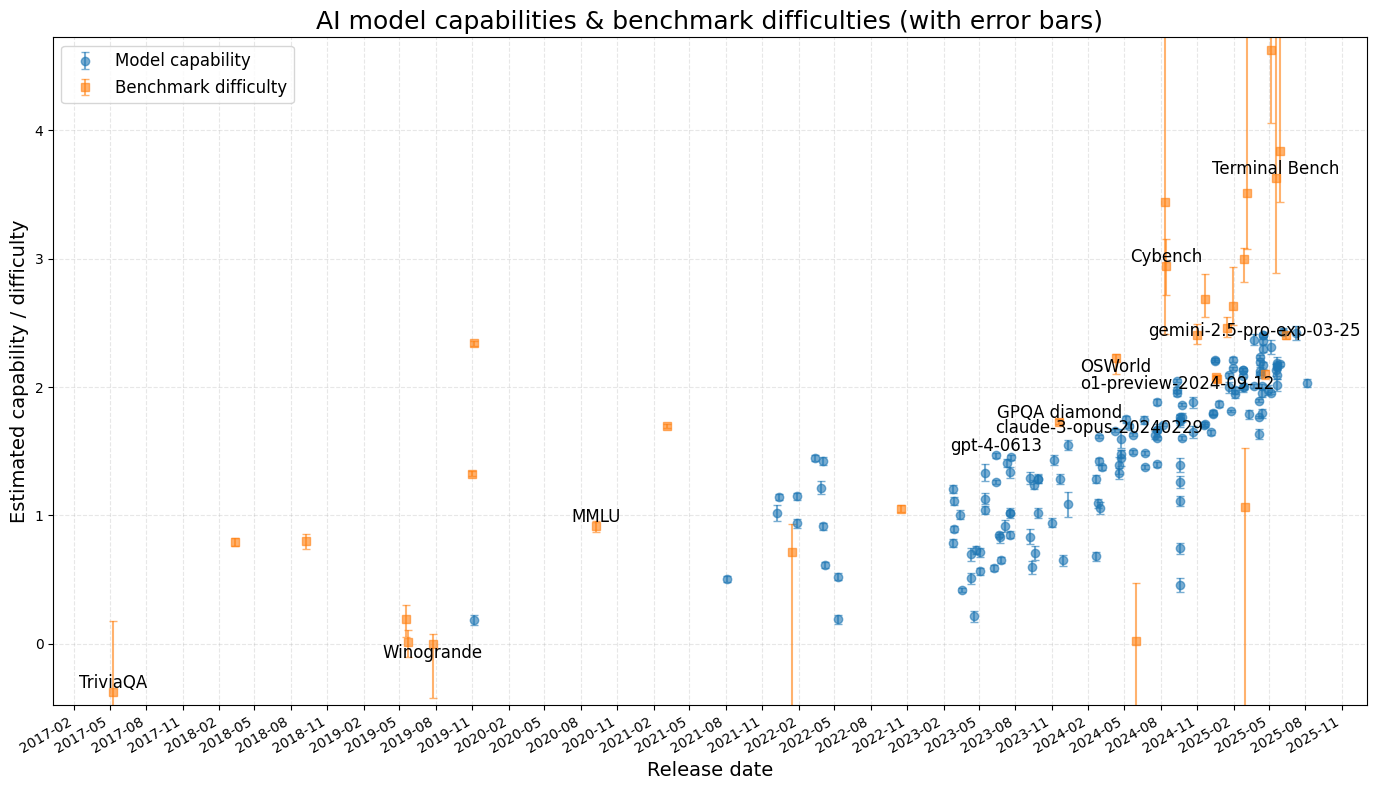


ERROR BAR STATISTICS

Model Capabilities:
  Mean error (minus): 0.0305
  Mean error (plus):  0.0303
  Median error (minus): 0.0296
  Median error (plus):  0.0295
  Max error (minus): 0.0970
  Max error (plus):  0.0992

Benchmark Difficulties:
  Mean error (minus): 0.6259
  Mean error (plus):  0.5331
  Median error (minus): 0.1232
  Median error (plus):  0.0847
  Max error (minus): 4.5798
  Max error (plus):  3.6577


In [7]:
# ── PLOT WITH ERROR BARS ──────────────────────────────────────────────────

# Merge error bars with the original data
cap_df_with_errors = df_cm1.merge(
    capability_errors[['model', 'error_minus', 'error_plus']], 
    on='model', 
    how='left'
)
bench_df_with_errors = df_db1.merge(
    difficulty_errors[['benchmark_name', 'error_minus', 'error_plus']], 
    on='benchmark_name', 
    how='left'
)

# Prepare data
cap_df_with_errors["date_obj"] = pd.to_datetime(cap_df_with_errors["date"])
cap_df_with_errors.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df_with_errors["date_obj"])
cap_values = cap_df_with_errors["estimated_capability"]

bench_df_with_errors["date_obj"] = pd.to_datetime(bench_df_with_errors["benchmark_release_date"])
bench_df_with_errors.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df_with_errors["date_obj"])
bench_values = bench_df_with_errors["estimated_difficulty"]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot with error bars
ax.errorbar(cap_dates_num, cap_values,
            yerr=[cap_df_with_errors["error_minus"], cap_df_with_errors["error_plus"]],
            fmt='o', markersize=6, capsize=3, capthick=1,
            color='tab:blue', ecolor='tab:blue', alpha=0.6,
            label='Model capability')

ax.errorbar(bench_dates_num, bench_values,
            yerr=[bench_df_with_errors["error_minus"], bench_df_with_errors["error_plus"]],
            fmt='s', markersize=6, capsize=3, capthick=1,
            color='tab:orange', ecolor='tab:orange', alpha=0.6,
            label='Benchmark difficulty')

# Annotate selected points (same as before)
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df_with_errors["model"])):
    if name not in annotate_models:
        continue
    y_offset = 0.05 if i % 2 == 0 else -0.05
    va = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    "GPQA diamond",
    "OSWorld",
    "Cybench",
    "Terminal Bench",
    "TriviaQA",
}

for i, (d, y, name) in enumerate(zip(bench_dates_num, bench_values, bench_df_with_errors["benchmark_name"])):
    if name not in annotate_benchmarks:
        continue
    y_offset = 0.05 if i % 2 == 0 else -0.05
    va = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# Axes cosmetics
ax.set_xlabel("Release date", fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties (with error bars)", fontsize=18)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

min_y = min(cap_values.min(), bench_values.min()) - 0.1
max_y = max(cap_values.max(), bench_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
# plt.savefig("capabilities_and_benchmarks_with_error_bars.pdf")
plt.show()

# Print some statistics about error bars
print("\n" + "="*60)
print("ERROR BAR STATISTICS")
print("="*60)
print(f"\nModel Capabilities:")
print(f"  Mean error (minus): {capability_errors['error_minus'].mean():.4f}")
print(f"  Mean error (plus):  {capability_errors['error_plus'].mean():.4f}")
print(f"  Median error (minus): {capability_errors['error_minus'].median():.4f}")
print(f"  Median error (plus):  {capability_errors['error_plus'].median():.4f}")
print(f"  Max error (minus): {capability_errors['error_minus'].max():.4f}")
print(f"  Max error (plus):  {capability_errors['error_plus'].max():.4f}")

print(f"\nBenchmark Difficulties:")
print(f"  Mean error (minus): {difficulty_errors['error_minus'].mean():.4f}")
print(f"  Mean error (plus):  {difficulty_errors['error_plus'].mean():.4f}")
print(f"  Median error (minus): {difficulty_errors['error_minus'].median():.4f}")
print(f"  Median error (plus):  {difficulty_errors['error_plus'].median():.4f}")
print(f"  Max error (minus): {difficulty_errors['error_minus'].max():.4f}")
print(f"  Max error (plus):  {difficulty_errors['error_plus'].max():.4f}")


Testing different loss increase thresholds...

Threshold: 1.0%

Threshold: 2.5%

Threshold: 5.0%

Threshold: 10.0%

Threshold: 15.0%


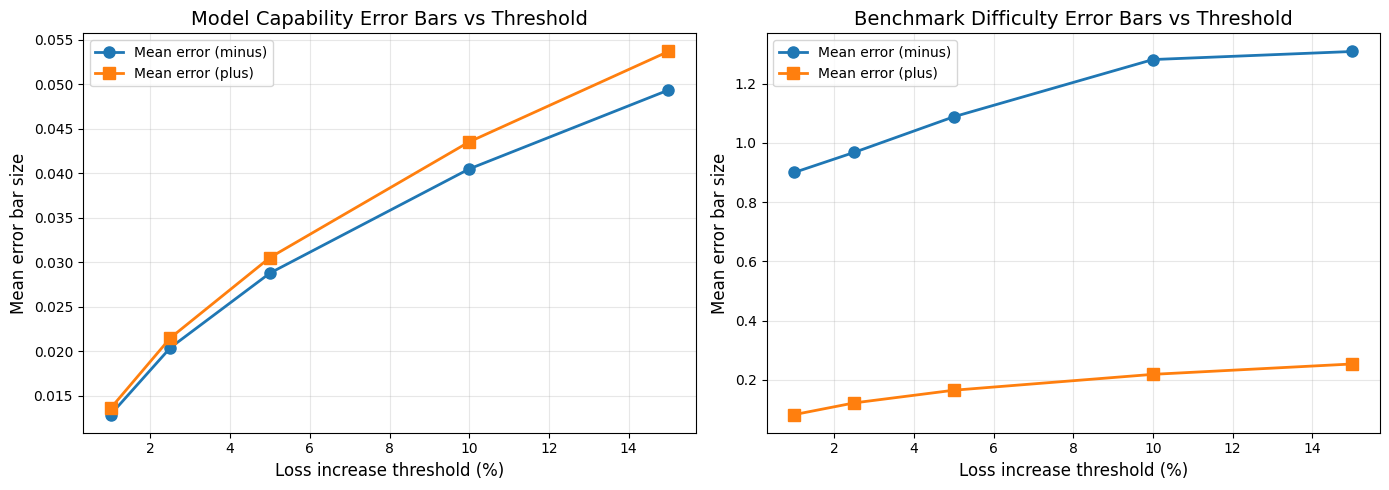


THRESHOLD SENSITIVITY ANALYSIS

As the threshold increases, error bars get larger (we allow more deviation)
The 5% threshold (0.05) is a reasonable default, but you can adjust it based on
how conservative you want your uncertainty estimates to be.


In [8]:
# ── SENSITIVITY ANALYSIS: Different Threshold Values ──────────────────────

# Test different thresholds
thresholds = [0.01, 0.025, 0.05, 0.10, 0.15]
threshold_results_cap = []
threshold_results_bench = []

print("Testing different loss increase thresholds...")
for threshold in thresholds:
    print(f"\nThreshold: {threshold*100}%")
    
    # Compute error bars with this threshold (only for a subset to save time)
    # Let's just compute for a few models and benchmarks to demonstrate
    cap_errors_sample = compute_capability_error_bars(
        df1, df_cm1.head(10), df_db1, loss_increase_threshold=threshold
    )
    
    bench_errors_sample = compute_difficulty_error_bars(
        df1, df_cm1, df_db1.head(10), loss_increase_threshold=threshold
    )
    
    threshold_results_cap.append({
        'threshold': threshold,
        'mean_error_minus': cap_errors_sample['error_minus'].mean(),
        'mean_error_plus': cap_errors_sample['error_plus'].mean()
    })
    
    threshold_results_bench.append({
        'threshold': threshold,
        'mean_error_minus': bench_errors_sample['error_minus'].mean(),
        'mean_error_plus': bench_errors_sample['error_plus'].mean()
    })

# Plot how error bars change with threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Capabilities
df_thresh_cap = pd.DataFrame(threshold_results_cap)
ax1.plot(df_thresh_cap['threshold'] * 100, df_thresh_cap['mean_error_minus'], 
         'o-', label='Mean error (minus)', linewidth=2, markersize=8)
ax1.plot(df_thresh_cap['threshold'] * 100, df_thresh_cap['mean_error_plus'], 
         's-', label='Mean error (plus)', linewidth=2, markersize=8)
ax1.set_xlabel('Loss increase threshold (%)', fontsize=12)
ax1.set_ylabel('Mean error bar size', fontsize=12)
ax1.set_title('Model Capability Error Bars vs Threshold', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Benchmarks
df_thresh_bench = pd.DataFrame(threshold_results_bench)
ax2.plot(df_thresh_bench['threshold'] * 100, df_thresh_bench['mean_error_minus'], 
         'o-', label='Mean error (minus)', linewidth=2, markersize=8)
ax2.plot(df_thresh_bench['threshold'] * 100, df_thresh_bench['mean_error_plus'], 
         's-', label='Mean error (plus)', linewidth=2, markersize=8)
ax2.set_xlabel('Loss increase threshold (%)', fontsize=12)
ax2.set_ylabel('Mean error bar size', fontsize=12)
ax2.set_title('Benchmark Difficulty Error Bars vs Threshold', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("THRESHOLD SENSITIVITY ANALYSIS")
print("="*60)
print("\nAs the threshold increases, error bars get larger (we allow more deviation)")
print("The 5% threshold (0.05) is a reasonable default, but you can adjust it based on")
print("how conservative you want your uncertainty estimates to be.")


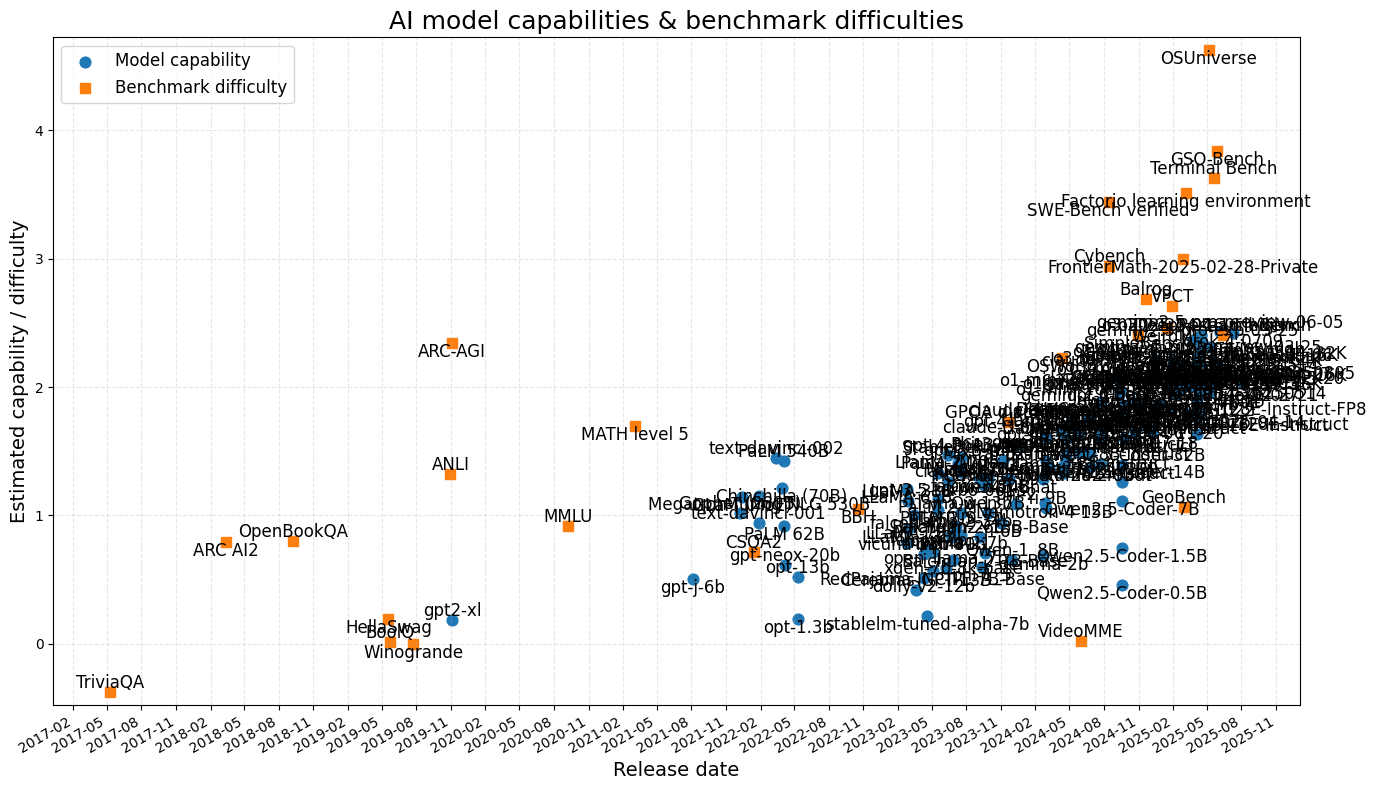

In [5]:
# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm1.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values    = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_db1.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values    = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot   = ax.scatter(cap_dates_num,   cap_values,
                        marker='o', s=60, color='tab:blue',  label='Model capability')
bench_plot = ax.scatter(bench_dates_num, bench_values,
                        marker='s', s=60, color='tab:orange', label='Benchmark difficulty')

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    # if name not in annotate_models:
    #     continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    "GPQA diamond",
    "OSWorld",
    "Cybench",
    "Terminal Bench",
    "TriviaQA",
}

for i, (d, y, name) in enumerate(zip(bench_dates_num, bench_values, bench_df["benchmark_name"])):
    # if name not in annotate_benchmarks:
    #     continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date",  fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = min(cap_values.min(),  bench_values.min()) - 0.1
max_y = max(cap_values.max(),  bench_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
# ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
# plt.savefig("capabilities_and_benchmarks_over_time.pdf")
plt.show()


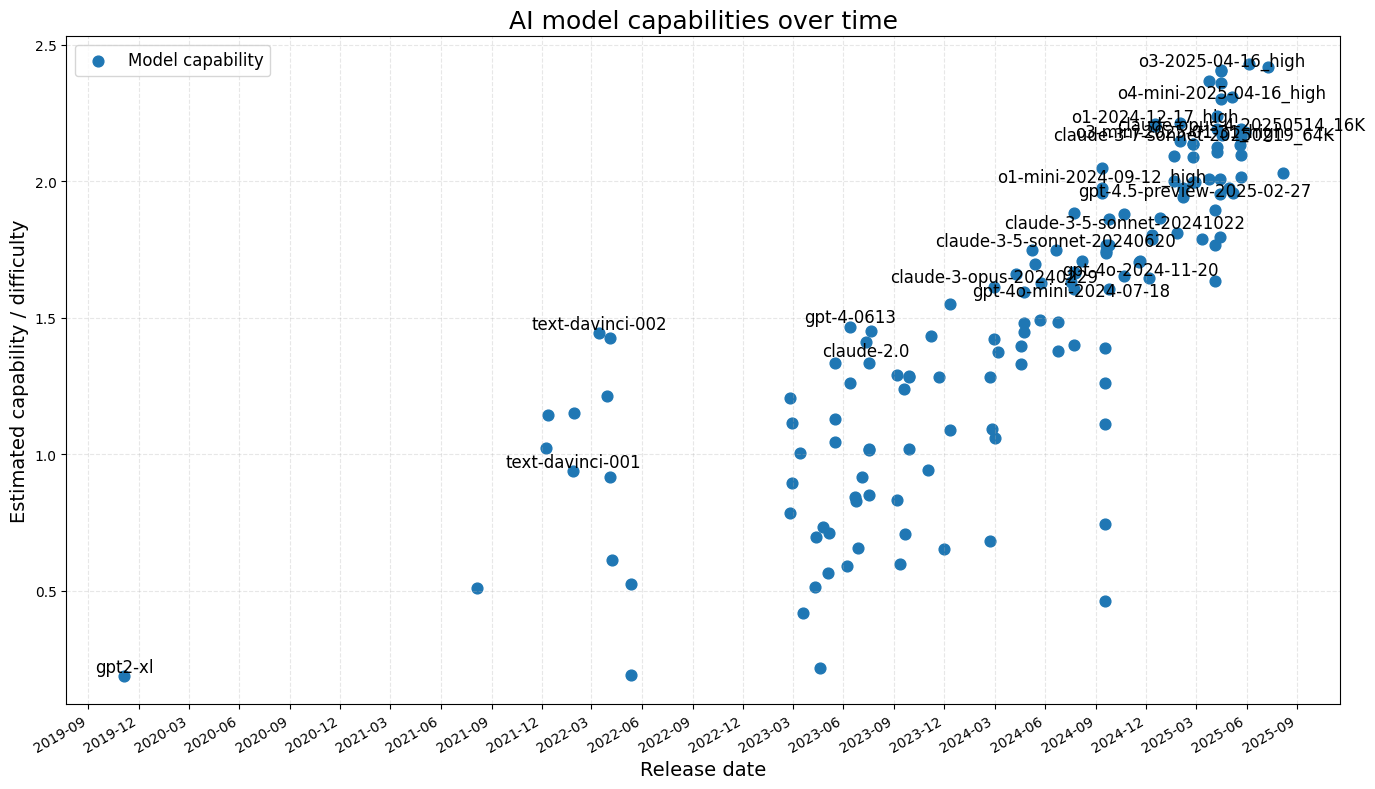

In [ ]:
# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm1.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values    = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_db1.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values    = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot   = ax.scatter(cap_dates_num,   cap_values,
                        marker='o', s=60, color='tab:blue',  label='Model capability')
# bench_plot = ax.scatter(bench_dates_num, bench_values,
#                         marker='s', s=60, color='tab:orange', label='Benchmark difficulty')

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    if name not in ref_models:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date",  fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities over time", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = cap_values.min() - 0.1
max_y = cap_values.max() + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
# ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
# plt.savefig("capabilities_over_time.pdf")
plt.show()


Bootstrapped mean rate: 0.4436 capability units/year
95% confidence interval: [0.3800, 0.5250]


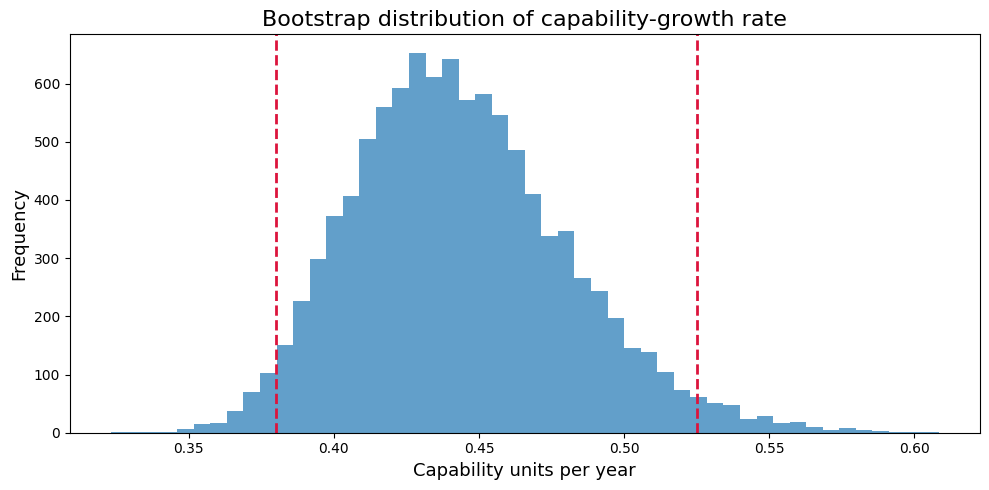

In [20]:
n_boot      = 10000          # number of bootstrap resamples
rng         = np.random.default_rng(0)   # reproducible seed

# x_full = cap_dates_num                       # days-since-0000-12-31 (float64)
# y_full = cap_values.to_numpy()         # capability values (float64)

mask = ~(np.isnan(cap_dates_num) | np.isnan(cap_values))
x_full = cap_dates_num[mask]
y_full = cap_values[mask]

boot_slopes_year = np.empty(n_boot)      # pre-allocate

for i in range(n_boot):
    # sample indices with replacement
    idx           = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _  = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year[i] = slope_day * 365.25   # convert to per-year

# point estimate & 95 % CI
mean_rate = boot_slopes_year.mean()
ci_lower, ci_upper = np.percentile(boot_slopes_year, [2.5, 97.5])

print(f"Bootstrapped mean rate: {mean_rate:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# ── (optional) visualise the bootstrap distribution ────────────────────
plt.figure(figsize=(10, 5))
plt.hist(boot_slopes_year, bins=50, alpha=0.7)
plt.axvline(ci_lower, color='crimson', linestyle='--', lw=2)
plt.axvline(ci_upper, color='crimson', linestyle='--', lw=2)
plt.title('Bootstrap distribution of capability-growth rate', fontsize=16)
plt.xlabel('Capability units per year', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.tight_layout()
plt.show()

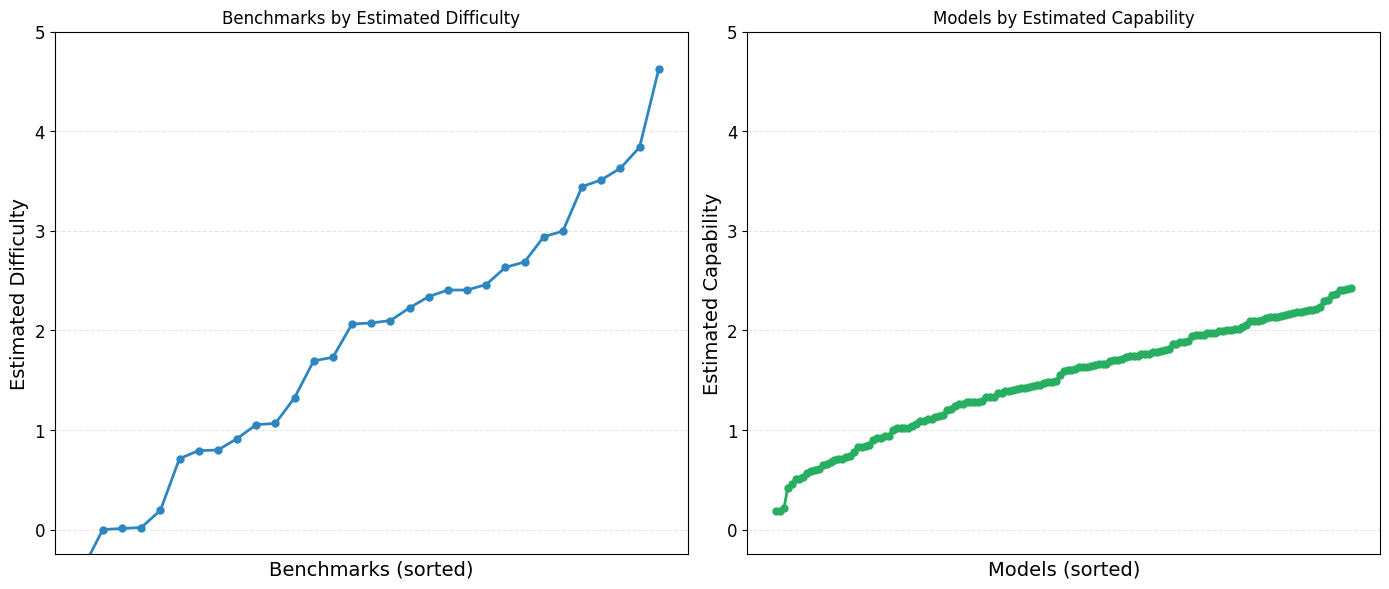

In [ ]:
# ---------- 1) Prepare the two ordered data sets ----------
# ------------- (exactly as in your originals) -------------
sorted_bd = df_db1.sort_values(by="estimated_difficulty").reset_index(drop=True)
bd_values  = sorted_bd["estimated_difficulty"]
bd_names   = sorted_bd["benchmark_name"]
bd_ids     = sorted_bd["benchmark_id"]
bd_idx     = np.arange(len(bd_values))

sorted_cm = df_cm1.sort_values(by="estimated_capability").reset_index(drop=True)
cm_values  = sorted_cm["estimated_capability"]
cm_names   = sorted_cm["model"]
cm_ids     = sorted_cm["model_id"]
cm_idx     = np.arange(len(cm_values))

# ---------- 2) Create a single figure with two sub-axes ----------
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(14, 8), sharey=False  # sharey=False because scales differ
)

# ---------- 3) First subplot: benchmark difficulties ----------
ax1.plot(bd_idx, bd_values, marker='o', linestyle='-', linewidth=2,
         markersize=5, color='#2E86C1')
ax1.set_xlabel('Benchmarks (sorted)', fontsize=14)
ax1.set_ylabel('Estimated Difficulty', fontsize=14)
ax1.set_title('Benchmarks by Estimated Difficulty')
# ax1.set_xticks(bd_idx)
# ax1.set_xticklabels(bd_ids, rotation=90)
ax1.set_xticks([])
ax1.grid(True, alpha=0.3, linestyle='--')
# ax1.axhspan(bd_values.min(), bd_values.max(), alpha=0.1, color='skyblue')

ax1.set_ylim(-0.25, 5)
ax1.tick_params(axis='y', labelsize=12)

# # optional min / max call-outs
# ax1.annotate(f'Min: {bd_values.min():.2f}', xy=(0, bd_values.min()),
#              xytext=(10, 20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)
# ax1.annotate(f'Max: {bd_values.max():.2f}', xy=(len(bd_values)-1, bd_values.max()),
#              xytext=(-50, -20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)

# ---------- 4) Second subplot: model capabilities ----------
ax2.plot(cm_idx, cm_values, marker='o', linestyle='-', linewidth=2,
         markersize=5, color='#27AE60')
ax2.set_xlabel('Models (sorted)', fontsize=14)
ax2.set_ylabel('Estimated Capability', fontsize=14)
ax2.set_title('Models by Estimated Capability')
# ax2.set_xticks(cm_idx)
# ax2.set_xticklabels(cm_ids, rotation=90)
ax2.set_xticks([])
ax2.grid(True, alpha=0.3, linestyle='--')
# ax2.axhspan(cm_values.min(), cm_values.max(), alpha=0.1, color='lightgreen')

ax2.set_ylim(-0.25, 5)
ax2.tick_params(axis='y', labelsize=12)

# ax2.annotate(f'Min: {cm_values.min():.2f}', xy=(0, cm_values.min()),
#              xytext=(10, 20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)
# ax2.annotate(f'Max: {cm_values.max():.2f}', xy=(len(cm_values)-1, cm_values.max()),
#              xytext=(-50, -20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)

# ---------- 5) Finish up ----------
# fig.suptitle('Benchmark Difficulty vs. Model Capability', fontsize=16, y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.95])   # leave room for the suptitle
plt.subplots_adjust(bottom=0.25)         # extra space for x-tick labels


# plt.savefig("model_and_benchmark_ranking.pdf")

plt.show()


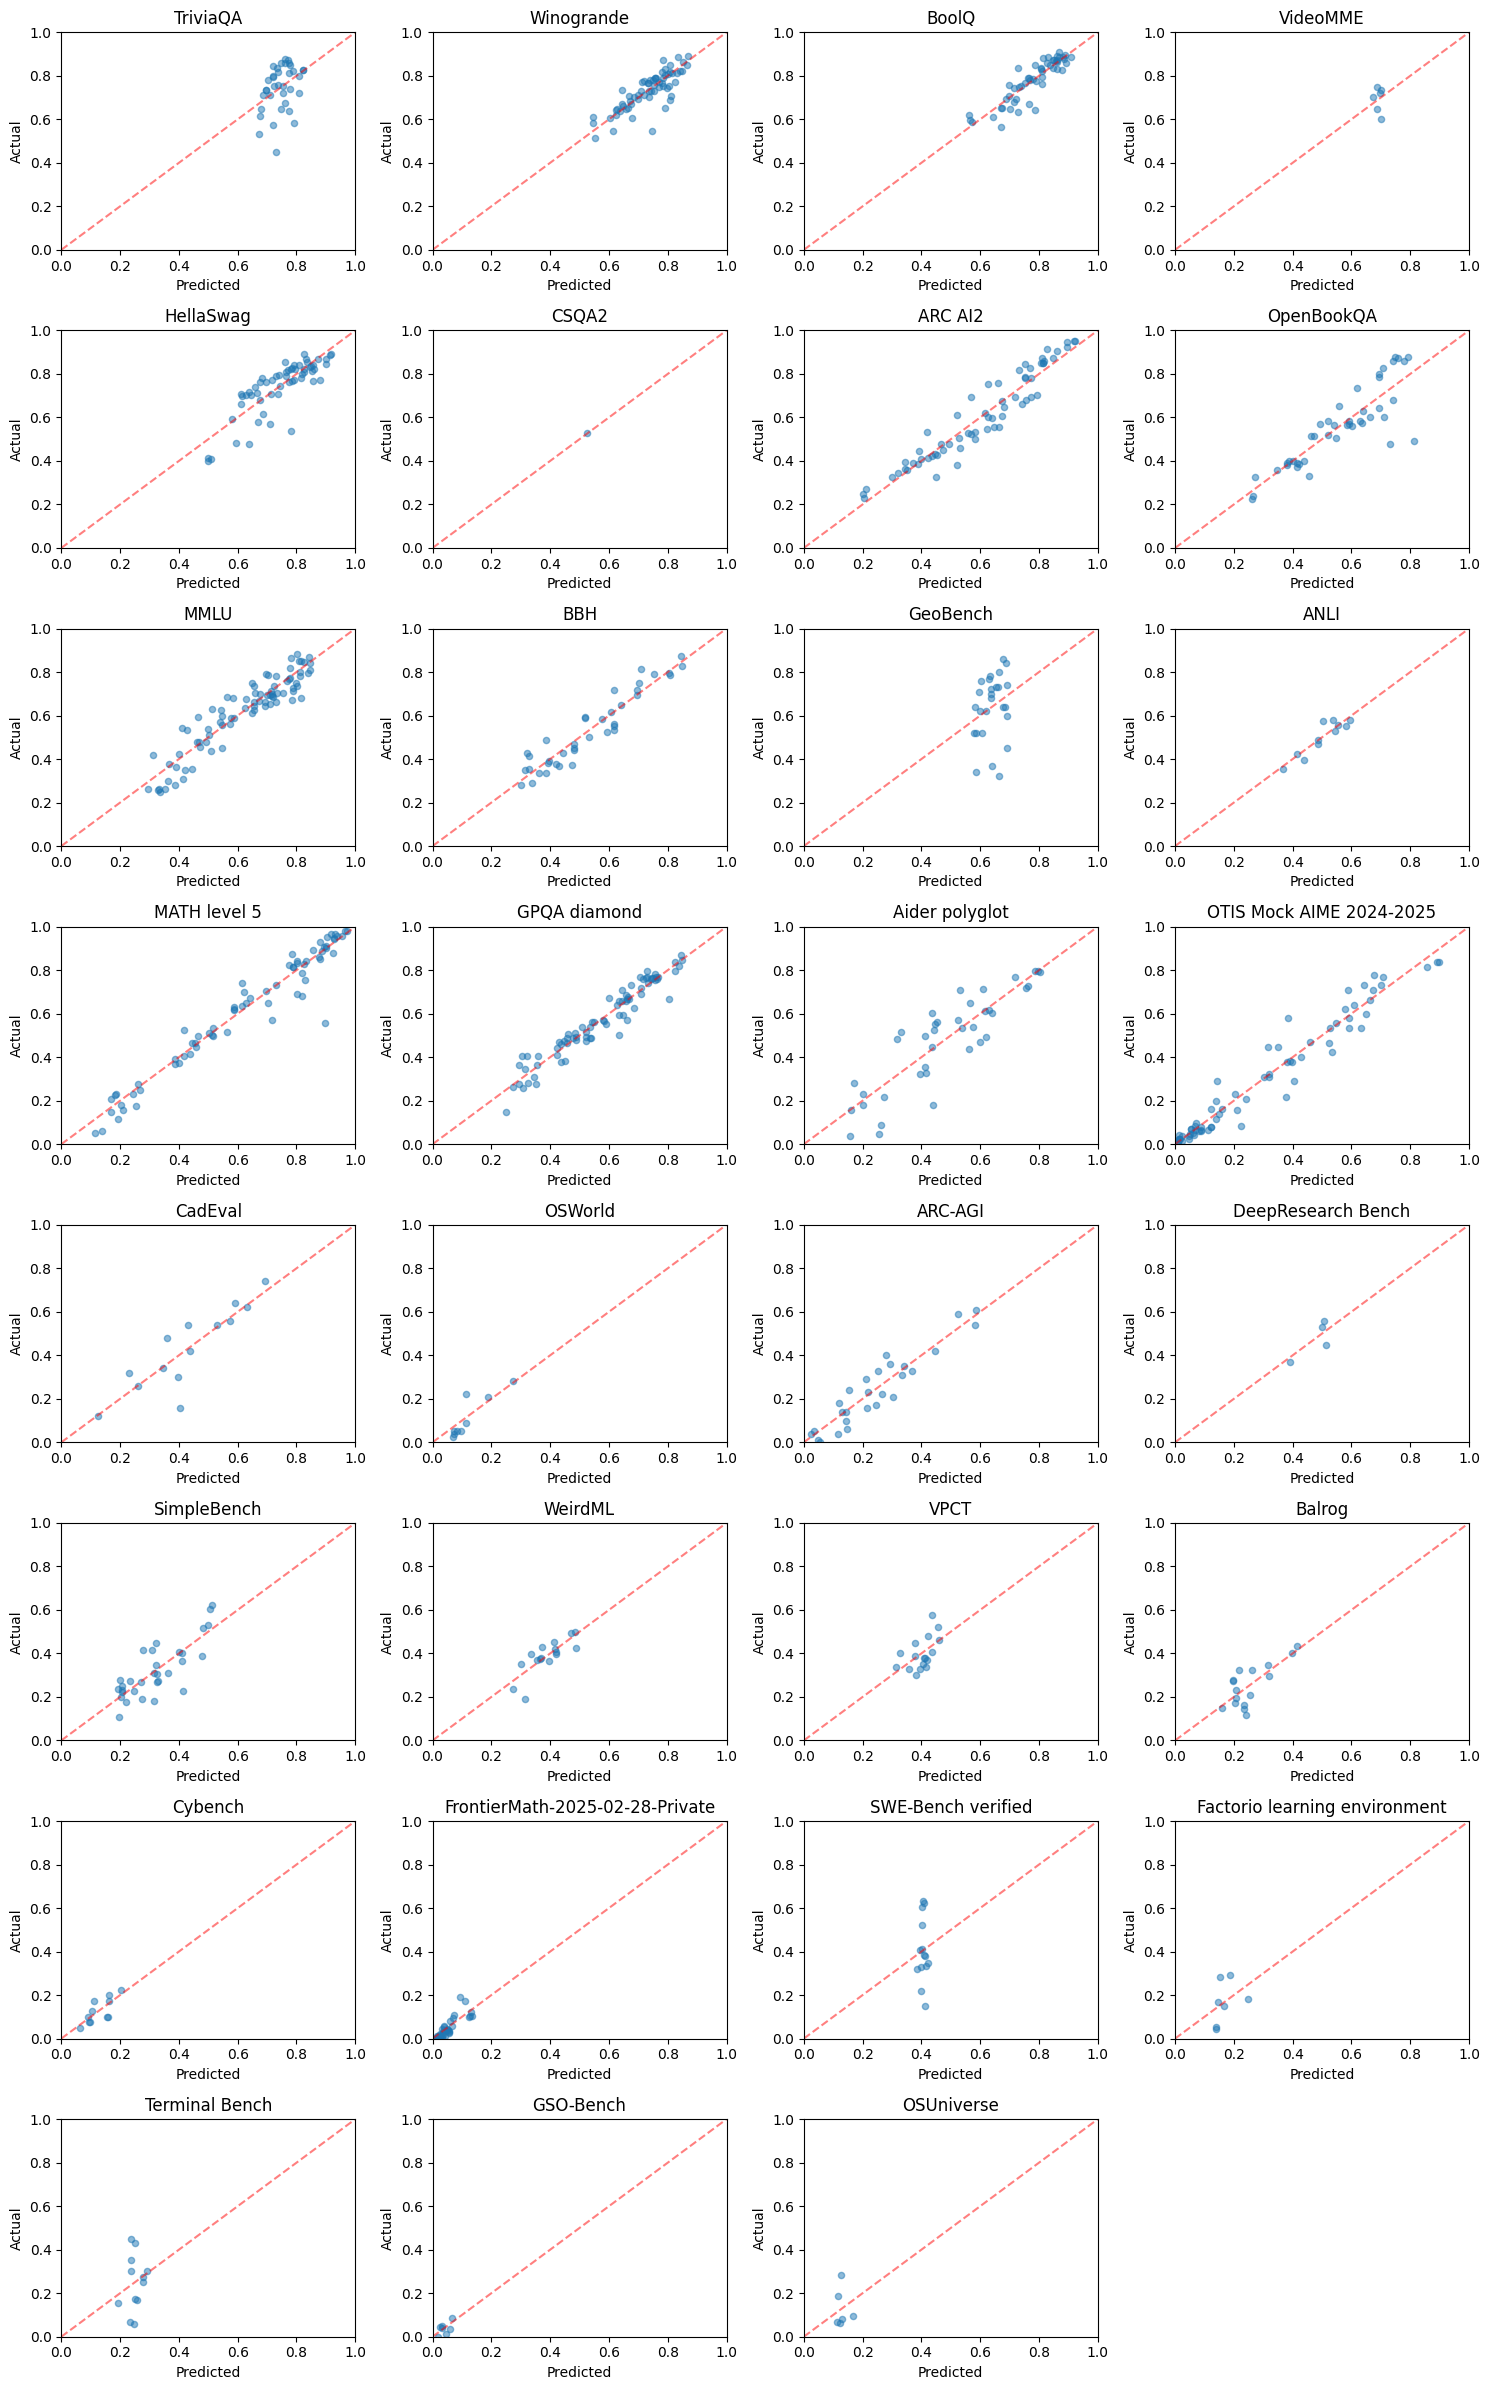

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

# Get unique benchmarks
benchmarks = df_db1['benchmark_name'].unique()

# Create subplots
n_benchmarks = len(benchmarks)
n_cols = 4
n_rows = (n_benchmarks + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

# Loop through each benchmark
for idx, benchmark in enumerate(benchmarks):
    ax = axes[idx]
    
    # Get data for this benchmark
    bench_data = df1[df1['benchmark'] == benchmark].copy()
    
    # Get benchmark parameters
    bench_params = df_db1[df_db1['benchmark_name'] == benchmark].iloc[0]
    D = bench_params['estimated_difficulty']
    alpha = bench_params['estimated_slope']
    
    # Merge with model capabilities
    bench_data = bench_data.merge(df_cm1[['model', 'estimated_capability']], on='model', how='left')
    
    # Calculate predicted performance
    bench_data['predicted'] = logistic(alpha * (bench_data['estimated_capability'] - D))
    
    # Plot
    ax.scatter(bench_data['predicted'], bench_data['performance'], alpha=0.5, s=20)
    ax.plot([0, 1], [0, 1], 'r--', alpha=0.5)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(benchmark)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# Hide unused subplots
for idx in range(n_benchmarks, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

SOTA-at-release points: 18
Annual growth rate (slope): 0.3810
R^2: 0.9258
Span: 2019-11-05  2025-06-05


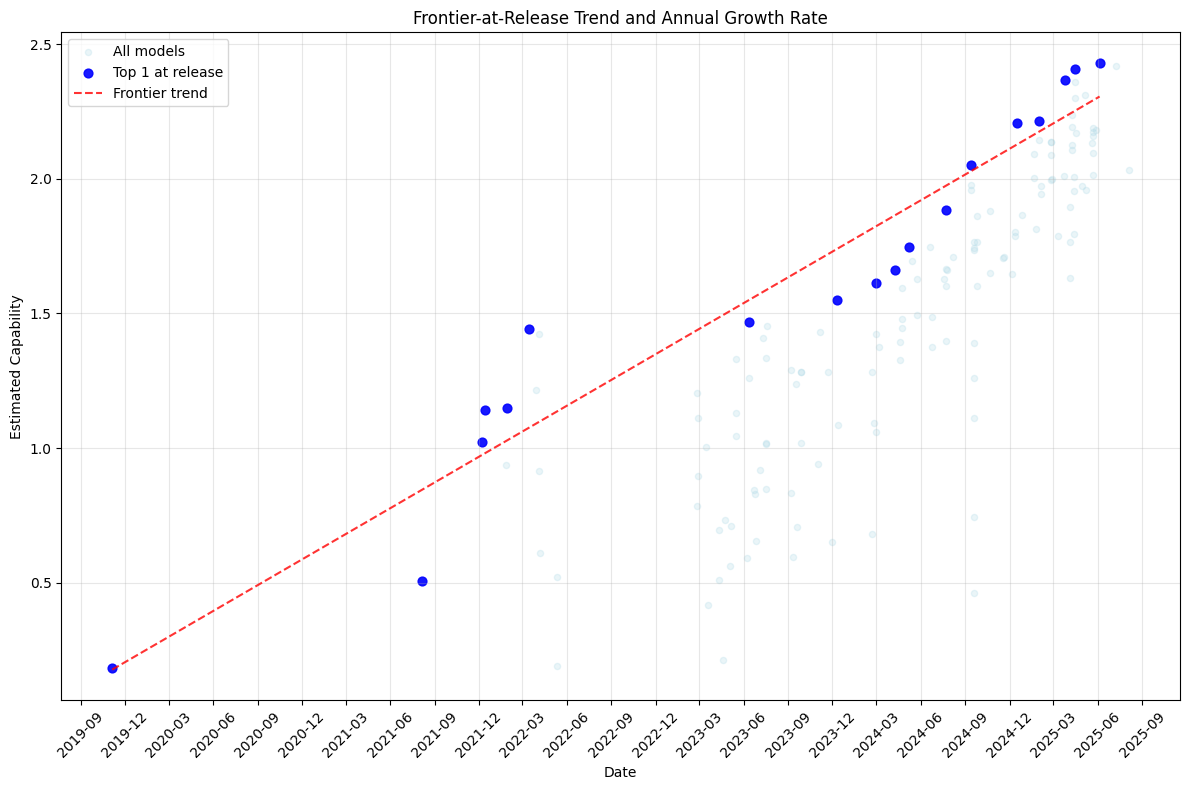

In [23]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Identify models that were SOTA (top-N) at their release and fit a trend
TOP_N_AT_RELEASE = 1  # change to >1 if you want top-N frontier, not strict SOTA

# Prepare data
df_all = df_cm1.copy()
# Ensure datetime
if 'date_obj' not in df_all.columns or not np.issubdtype(df_all['date_obj'].dtype, np.datetime64):
    df_all['date_obj'] = pd.to_datetime(df_all['date'])

df_all = df_all.dropna(subset=['date_obj', 'estimated_capability']).sort_values('date_obj').reset_index(drop=True)

# Compute frontier-at-release
frontier_rows = []
for _, row in df_all.iterrows():
    release_date = row['date_obj']
    available = df_all[df_all['date_obj'] <= release_date]
    top_at_release = available.nlargest(TOP_N_AT_RELEASE, 'estimated_capability')
    if row['model'] in top_at_release['model'].values:
        frontier_rows.append(row)

df_frontier = pd.DataFrame(frontier_rows).sort_values('date_obj').reset_index(drop=True)

# Fit linear trend through frontier points
if len(df_frontier) >= 2:
    X = (df_frontier['date_obj'] - df_frontier['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y = df_frontier['estimated_capability'].values
    lr = LinearRegression()
    lr.fit(X, y)
    slope_per_year = lr.coef_[0] * 365.25
    r2 = lr.score(X, y)
else:
    lr = None
    slope_per_year = np.nan
    r2 = np.nan

print("SOTA-at-release points:", len(df_frontier))
print(f"Annual growth rate (slope): {slope_per_year:.4f}")
print(f"R^2: {r2:.4f}")
if len(df_frontier) > 0:
    print(f"Span: {df_frontier.iloc[0]['date']}  {df_frontier.iloc[-1]['date']}")

# Plot: all points, frontier points, and trendline
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(df_all['date_obj'], df_all['estimated_capability'], alpha=0.25, s=20, label='All models', color='lightblue')
ax.scatter(df_frontier['date_obj'], df_frontier['estimated_capability'], alpha=0.9, s=40, label=f'Top {TOP_N_AT_RELEASE} at release', color='blue')

if lr is not None:
    X_plot = (df_frontier['date_obj'] - df_frontier['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y_pred = lr.predict(X_plot)
    ax.plot(df_frontier['date_obj'], y_pred, 'r--', alpha=0.8, label='Frontier trend')

ax.set_xlabel('Date')
ax.set_ylabel('Estimated Capability')
ax.set_title('Frontier-at-Release Trend and Annual Growth Rate')
ax.grid(True, alpha=0.3)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Line of best fit slope: 0.4400 capability units/year
R-squared: 0.6415


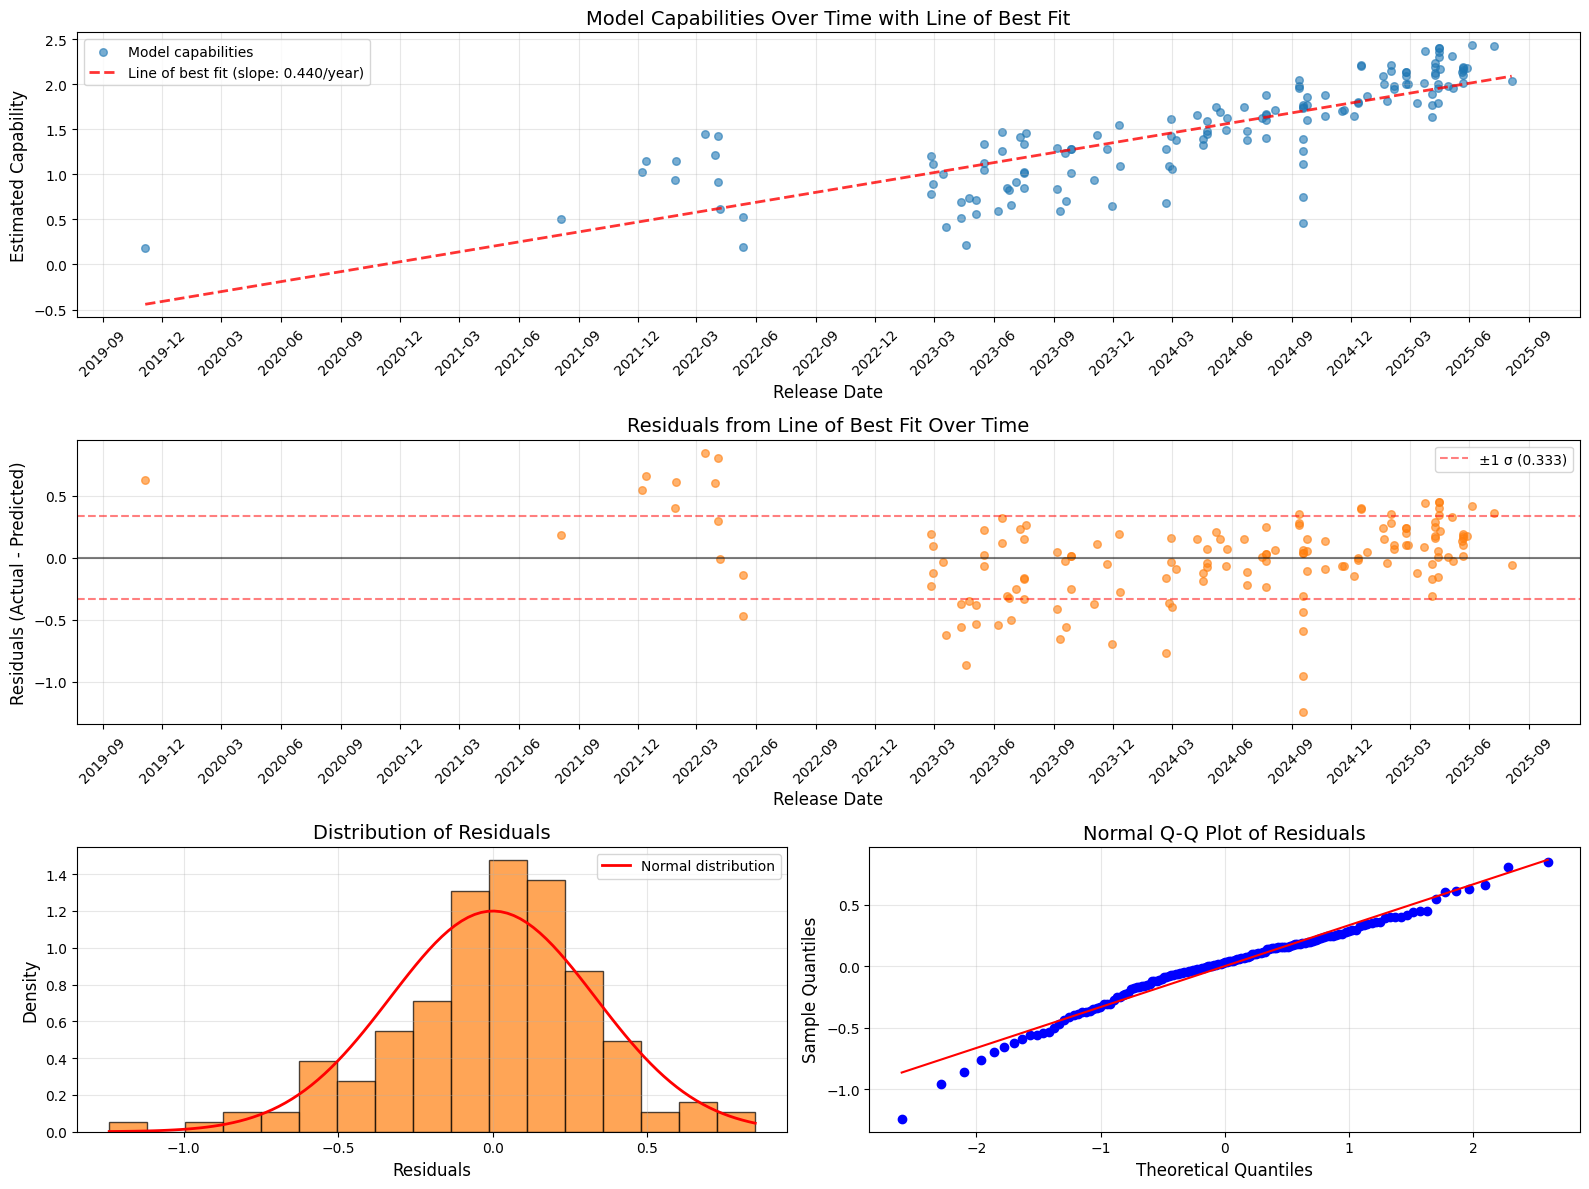


NORMALITY TESTS FOR RESIDUALS

Basic Statistics:
  Mean: -0.000000
  Standard Deviation: 0.3337
  Skewness: -0.5754
  Kurtosis: 1.1651
  Min: -1.2406
  Max: 0.8483
  Sample size: 149

Kolmogorov-Smirnov Test:
  Test statistic: 0.0877
  P-value: 0.1903
  Interpretation: FAIL TO REJECT null hypothesis of normality (α=0.05)

Shapiro-Wilk Test:
  Test statistic: 0.9742
  P-value: 0.0066
  Interpretation: REJECT null hypothesis of normality (α=0.05)

Anderson-Darling Test:
  Test statistic: 1.2280
  Critical values: [0.562 0.64  0.767 0.895 1.065]
  Significance levels: [15.  10.   5.   2.5  1. ]%
  Interpretation: REJECT null hypothesis of normality (α=0.05)

Jarque-Bera Test:
  Test statistic: 16.6504
  P-value: 0.0002
  Interpretation: REJECT null hypothesis of normality (α=0.05)

SUMMARY FOR SYNTHETIC DATA GENERATION

Normality test summary: 3/4 tests reject normality
Recommendation: ✗ GAUSSIAN NOISE assumption is NOT SUPPORTED - consider alternative noise distributions

Additional con

In [ ]:
# Residuals analysis with normality testing for synthetic data generation
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import scipy.stats as stats

# Prepare data for residuals analysis
cap_df = df_cm1.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df = cap_df.dropna(subset=['date_obj', 'estimated_capability']).sort_values('date_obj').reset_index(drop=True)

# Convert dates to numerical format for regression
X = (cap_df['date_obj'] - cap_df['date_obj'].min()).dt.days.values.reshape(-1, 1)
y = cap_df['estimated_capability'].values

# Fit linear regression (line of best fit)
lr = LinearRegression()
lr.fit(X, y)

# Calculate predicted values and residuals
y_pred = lr.predict(X)
residuals = y - y_pred

# Convert slope to per-year rate
slope_per_year = lr.coef_[0] * 365.25
r2 = lr.score(X, y)

print(f"Line of best fit slope: {slope_per_year:.4f} capability units/year")
print(f"R-squared: {r2:.4f}")

# Create comprehensive residuals analysis plot
fig = plt.figure(figsize=(16, 12))

# 1. Time series plot with line of best fit
ax1 = plt.subplot(3, 2, (1, 2))
ax1.scatter(cap_df['date_obj'], cap_df['estimated_capability'], alpha=0.6, s=30, color='tab:blue', label='Model capabilities')
ax1.plot(cap_df['date_obj'], y_pred, 'r--', alpha=0.8, linewidth=2, label=f'Line of best fit (slope: {slope_per_year:.3f}/year)')
ax1.set_xlabel('Release Date', fontsize=12)
ax1.set_ylabel('Estimated Capability', fontsize=12)
ax1.set_title('Model Capabilities Over Time with Line of Best Fit', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# 2. Residuals over time
ax2 = plt.subplot(3, 2, (3, 4))
ax2.scatter(cap_df['date_obj'], residuals, alpha=0.6, s=30, color='tab:orange')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
std_residuals = np.std(residuals)
ax2.axhline(y=std_residuals, color='red', linestyle='--', alpha=0.5, label=f'±1 σ ({std_residuals:.3f})')
ax2.axhline(y=-std_residuals, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Release Date', fontsize=12)
ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
ax2.set_title('Residuals from Line of Best Fit Over Time', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# 3. Histogram of residuals with normal overlay
ax3 = plt.subplot(3, 2, 5)
n_bins = int(np.sqrt(len(residuals))) + 5  # Sturges' rule with buffer
counts, bins, patches = ax3.hist(residuals, bins=n_bins, density=True, alpha=0.7, color='tab:orange', edgecolor='black')

# Overlay normal distribution
x_norm = np.linspace(residuals.min(), residuals.max(), 100)
normal_overlay = stats.norm.pdf(x_norm, np.mean(residuals), np.std(residuals))
ax3.plot(x_norm, normal_overlay, 'r-', linewidth=2, label='Normal distribution')
ax3.set_xlabel('Residuals', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title('Distribution of Residuals', fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.legend()

# 4. Q-Q plot
ax4 = plt.subplot(3, 2, 6)
stats.probplot(residuals, dist="norm", plot=ax4)
ax4.set_xlabel('Theoretical Quantiles', fontsize=12)
ax4.set_ylabel('Sample Quantiles', fontsize=12)
ax4.set_title('Normal Q-Q Plot of Residuals', fontsize=14)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig("model_capabilities_residuals_normality_analysis.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Statistical tests for normality
print(f"\n" + "="*60)
print("NORMALITY TESTS FOR RESIDUALS")
print("="*60)

# Basic statistics
print(f"\nBasic Statistics:")
print(f"  Mean: {np.mean(residuals):.6f}")
print(f"  Standard Deviation: {np.std(residuals, ddof=1):.4f}")
print(f"  Skewness: {stats.skew(residuals):.4f}")
print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")
print(f"  Min: {np.min(residuals):.4f}")
print(f"  Max: {np.max(residuals):.4f}")
print(f"  Sample size: {len(residuals)}")

# Kolmogorov-Smirnov test
ks_stat, ks_pvalue = stats.kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals)))
print(f"\nKolmogorov-Smirnov Test:")
print(f"  Test statistic: {ks_stat:.4f}")
print(f"  P-value: {ks_pvalue:.4f}")
print(f"  Interpretation: {'REJECT' if ks_pvalue < 0.05 else 'FAIL TO REJECT'} null hypothesis of normality (α=0.05)")

# Shapiro-Wilk test (more powerful for small to moderate sample sizes)
if len(residuals) <= 5000:  # Shapiro-Wilk works best for n <= 5000
    sw_stat, sw_pvalue = stats.shapiro(residuals)
    print(f"\nShapiro-Wilk Test:")
    print(f"  Test statistic: {sw_stat:.4f}")
    print(f"  P-value: {sw_pvalue:.4f}")
    print(f"  Interpretation: {'REJECT' if sw_pvalue < 0.05 else 'FAIL TO REJECT'} null hypothesis of normality (α=0.05)")

# Anderson-Darling test
ad_stat, ad_critical_vals, ad_significance_levels = stats.anderson(residuals, dist='norm')
print(f"\nAnderson-Darling Test:")
print(f"  Test statistic: {ad_stat:.4f}")
print(f"  Critical values: {ad_critical_vals}")
print(f"  Significance levels: {ad_significance_levels}%")
# Find the appropriate critical value for 5% significance
ad_5pct_critical = ad_critical_vals[np.where(ad_significance_levels == 5)[0][0]] if 5 in ad_significance_levels else ad_critical_vals[2]
print(f"  Interpretation: {'REJECT' if ad_stat > ad_5pct_critical else 'FAIL TO REJECT'} null hypothesis of normality (α=0.05)")

# Jarque-Bera test
jb_stat, jb_pvalue = stats.jarque_bera(residuals)
print(f"\nJarque-Bera Test:")
print(f"  Test statistic: {jb_stat:.4f}")
print(f"  P-value: {jb_pvalue:.4f}")
print(f"  Interpretation: {'REJECT' if jb_pvalue < 0.05 else 'FAIL TO REJECT'} null hypothesis of normality (α=0.05)")

print(f"\n" + "="*60)
print("SUMMARY FOR SYNTHETIC DATA GENERATION")
print("="*60)

# Count how many tests reject normality
tests_results = [
    ("Kolmogorov-Smirnov", ks_pvalue < 0.05),
    ("Jarque-Bera", jb_pvalue < 0.05),
    ("Anderson-Darling", ad_stat > ad_5pct_critical)
]

if len(residuals) <= 5000:
    tests_results.append(("Shapiro-Wilk", sw_pvalue < 0.05))

rejections = sum([result[1] for result in tests_results])
total_tests = len(tests_results)

print(f"\nNormality test summary: {rejections}/{total_tests} tests reject normality")
if rejections == 0:
    recommendation = "✓ GAUSSIAN NOISE assumption appears REASONABLE for synthetic data"
elif rejections <= total_tests // 2:
    recommendation = "⚠ GAUSSIAN NOISE assumption is QUESTIONABLE - consider checking sample size or alternative distributions"
else:
    recommendation = "✗ GAUSSIAN NOISE assumption is NOT SUPPORTED - consider alternative noise distributions"

print(f"Recommendation: {recommendation}")

# Additional diagnostics
print(f"\nAdditional considerations:")
if abs(stats.skew(residuals)) > 0.5:
    print(f"  • Residuals show notable skewness ({stats.skew(residuals):.3f})")
if abs(stats.kurtosis(residuals)) > 1.0:
    print(f"  • Residuals show notable kurtosis ({stats.kurtosis(residuals):.3f})")
if len(residuals) < 30:
    print(f"  • Small sample size (n={len(residuals)}) - normality tests have limited power")

print(f"\nFor synthetic data generation:")
print(f"  • Estimated noise std: {np.std(residuals, ddof=1):.4f}")
print(f"  • Suggested distribution: {'Normal(0, {:.4f})'.format(np.std(residuals, ddof=1)) if rejections == 0 else 'Consider empirical distribution or robust alternatives'}")

# Show models with extreme residuals
print(f"\nModels with largest absolute residuals (potential outliers):")
abs_residuals_idx = np.argsort(np.abs(residuals))[-5:]
for idx in abs_residuals_idx[::-1]:
    model_name = cap_df.iloc[idx]['model']
    residual_val = residuals[idx]
    print(f"  {model_name}: {residual_val:.4f}")